In [1]:
#!pip install --upgrade pip imbalanced-learn
#!pip install tensorflow-gpu==1.14

In [2]:
import pickle
from imblearn.under_sampling import RandomUnderSampler
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import tensorflow.keras as K
from sklearn.preprocessing import normalize as scikit_normalize
import matplotlib.pyplot as plt
from sklearn.utils import shuffle as  sklearn_shuffle
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from math import sqrt
import math
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [3]:
DATASET='/home/kvassay/data/z/data/reviews_train_test_dev1.pickle'

## Load data

In [4]:
with open(DATASET,'rb') as f:
    train,dev,test=pickle.load(f)

## Train TF-IDF model

In [5]:
def tfidf_train(dataset, **scikit_kwargs):
    vectorizer=TfidfVectorizer(**scikit_kwargs)
    vectorizer.fit([x['text'] for x in dataset])
    return vectorizer

def tfidf_predict(vectorizer,dataset, apply_norm=True):
    features=vectorizer.transform([x['text'] for x in dataset])
    if apply_norm is True:
        features=scikit_normalize(features)
    return features

In [6]:
%%time
vectorizer=tfidf_train(train,max_features=100000,max_df=0.8,ngram_range=(1,2))

CPU times: user 1min 19s, sys: 2.19 s, total: 1min 22s
Wall time: 1min 22s


## Extract features

In [7]:
%%time
X_train=tfidf_predict(vectorizer,train)
X_dev=tfidf_predict(vectorizer,dev)
y_train=np.array([x['score'] for x in train])
y_dev=np.array([x['score'] for x in dev])
print('Train samples shape: {}, Dev samples shape: {}'.format(X_train.shape,X_dev.shape))

Train samples shape: (551399, 100000), Dev samples shape: (8527, 100000)
CPU times: user 1min 5s, sys: 1.12 s, total: 1min 6s
Wall time: 1min 6s


## Training

In [8]:
class UnderSampler(K.utils.Sequence):

    def __init__(self, X, y, batch_size):
        self.rus=RandomUnderSampler(sampling_strategy='not minority')
        self.X, self.y = X, y
        self.batch_size = batch_size
        #len
        self._shuffle()
        self.length= math.ceil(self.X_u.shape[0] / self.batch_size)

    def _shuffle(self):
        self.X_u, self.y_u=self.rus.fit_resample(self.X,self.y)
        self.X_u,self.y_u = sklearn_shuffle(self.X_u,self.y_u)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = self.X_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.todense(), batch_y
    
    def on_epoch_end(self):
        self._shuffle()
        
class RandomSampler(K.utils.Sequence):

    def __init__(self, X, y, batch_size):
        self.X, self.y = X, y
        self.batch_size = batch_size
        self.sampling_size=np.min([x for (_,x) in dict(Counter(y)).items()])*len(set(y))
        #len
        self._shuffle()
        self.length= math.ceil(self.X_u.shape[0] / self.batch_size)

    def _shuffle(self):
        self.X_u,_,self.y_u,_=train_test_split(self.X,self.y,shuffle=True,train_size=self.sampling_size)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = self.X_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_u[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.todense(),batch_y
    
    def on_epoch_end(self):
        self._shuffle()

In [9]:
def train_model(batch_size=200, epochs=5, sampler_cls=UnderSampler):
    model = K.models.Sequential([
        K.layers.Dense(200,activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='glorot_normal'),
        K.layers.Dense(1,activation='linear',kernel_initializer='glorot_normal'),
    ])
    opt=K.optimizers.Adam(lr=0.02, amsgrad=True)
    model.compile(optimizer=opt,loss='mean_squared_error')
    sampler=sampler_cls(X_train,y_train,batch_size=batch_size)
    model.fit_generator(sampler, shuffle=False, epochs=epochs, validation_data=(X_dev.todense(),y_dev))
    return model

## Evaluate

In [10]:
def plot_history(model,title):
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='MSE Train')
    plt.plot(epochs, val_loss, color='green', label='MSE Dev')
    plt.title(title)
    plt.xlabel('Epochs') 
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

def rmse_partial(y_true, y_pred):
    all_scores=list(set(y_true))
    y_true_dict={x:[] for x in all_scores}
    y_pred_dict={x:[] for x in all_scores}
    for i, score in enumerate(y_true):
        y_true_dict[score].append(score)
        y_pred_dict[score].append(y_pred[i])
    return {score: rmse(y_true_dict[score],y_pred_dict[score]) for score in all_scores}
        
def rmse_partial_avg(y_true, y_pred):
    rmse_dict=rmse_partial(y_true,y_pred)
    values=list(rmse_dict.values())
    return np.mean(values), np.std(values)

def rmse_partial_max(y_true, y_pred):
    rmse_dict=rmse_partial(y_true,y_pred)
    values=list(rmse_dict.values())
    return np.max(values)

def rmse_report(y_true,y_pred,round_decimals=3, title='RMSE report'):
    def ar(x):
        return np.around(x,decimals=round_decimals)
    baseline=rmse(y_true,[5.0]*len(y_true))
    HTML_TEMPLATE="""
    <h2> {} </h2>
    <h3> RMSE </h3>
    <hr>
    <div>
        <table>
            <tr>
                <td>RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>RMSE</td>
                <td>{}</td>
            </tr>
        </table>
    <hr>
    <h3> Partial RMSE </h3>
        <table>
            <tr>
                <td>Mean partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Max partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>St.dev. partial RMSE (baseline &forall;1.0)</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Mean partial RMSE</td>
                <td><b>{}</b></td>
            </tr>
            <tr>
                <td>Max partial RMSE</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>St.dev. partial RMSE</td>
                <td>{}</td>
            </tr>            
        </table>
    </div>
    <h3> Improvement over baseline (&forall;1.0) </h3>
    <hr>
    <div>
        <table>
            <tr>
                <td>RMSE</td>
                <td>{}</td>
            </tr>
            <tr>
                <td>Mean partial RMSE</td>
                <td><b>{}</b></td>
            </tr>
            <tr>
                <td>Max partial RMSE</td>
                <td>{}</td>
            </tr>
        </table>
    </div>
    
    <h3> Partial RMSE detailed</h3>
    <hr>
    <div>
        <table>
            <tr>
                <th>Review Score</th>
                <th>RMSE</th>
                <th>RMSE baseline (&forall;1.0)</th>
                <th>Improvement over baseline</th>
            </tr>
            {}
        </table>
    </div>
    """
    PARTIAL_ROW_TEMPLATE='''
    <tr>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
        <td>
            {}
        </td>
    </tr>
    '''
    overall=rmse(y_true,y_pred)
    partial_avg,partial_std=rmse_partial_avg(y_true,y_pred)
    partial_max=rmse_partial_max(y_true,y_pred)
    partial_avg_baseline,partial_std_baseline=rmse_partial_avg(y_true,[5.0]*len(y_true))
    partial_max_baseline=rmse_partial_max(y_true,[5.0]*len(y_true))
    improvement_marmse=partial_avg_baseline-partial_avg
    improvement_rmse=baseline-overall
    improvement_rmse_partial_max=partial_max_baseline - partial_max
    
    #partial rows
    partial=rmse_partial(y_true,y_pred)
    partial_baseline=rmse_partial(y_true, [5.0]*len(y_true))
    partial=sorted(partial.items(),key=lambda x:x[0],reverse=True)
    partial_table_rows=[]
    for key,value in partial:
        value_baseline=partial_baseline[key]
        diff_baseline=value_baseline-value
        partial_table_rows.append(PARTIAL_ROW_TEMPLATE.format(key,ar(value),ar(value_baseline),ar(diff_baseline)))
    partial_table_rows='\n'.join(partial_table_rows)
    
    html=HTML_TEMPLATE.format(title,
                              ar(baseline),
                              ar(overall),
                              ar(partial_avg_baseline),
                              ar(partial_std_baseline),
                              ar(partial_max_baseline),
                              ar(partial_avg),
                              ar(partial_std),
                              ar(partial_max),
                              ar(improvement_rmse),
                              ar(improvement_marmse),
                              ar(improvement_rmse_partial_max),
                              partial_table_rows)
    display(HTML(html))

def experiment(sampling_cls,epochs,batch_size,name):
    model=train_model(sampler_cls=sampling_cls,epochs=epochs,batch_size=batch_size)
    y_pred_dev=model.predict(X_dev)
    rmse_report(y_dev,y_pred_dev,title='{} - RMSE report'.format(name))
    plot_history(model,title='{} - Train/Dev MSE'.format(name))
    return model

W0823 23:18:58.951363 140144221595456 deprecation.py:506] From /home/kvassay/.virtualenvs/main/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/15
290/290 [==============================] - 104s 359ms/step - loss: 1.0116 - val_loss: 0.9710
Epoch 2/15
290/290 [==============================] - 104s 358ms/step - loss: 0.5678 - val_loss: 0.8861
Epoch 3/15
290/290 [==============================] - 103s 356ms/step - loss: 0.4743 - val_loss: 0.8554
Epoch 4/15
290/290 [==============================] - 104s 359ms/step - loss: 0.4345 - val_loss: 0.7847
Epoch 5/15
290/290 [==============================] - 102s 353ms/step - loss: 0.3959 - val_loss: 0.7678
Epoch 6/15
290/290 [==============================] - 102s 353ms/step - loss: 0.3572 - val_loss: 0.7404
Epoch 7/15
290/290 [==============================] - 103s 354ms/step - loss: 0.3231 - val_loss: 0.6976
Epoch 8/15
290/290 [==============================] - 103s 354ms/step - loss: 0.2850 - val_loss: 0.6684
Epoch 9/15
290/290 [==============================] - 104s 358ms/step - loss: 0.2560 - val_loss: 0.6408
Epoch 10/15
290/290 [==============================] - 102s 351m

RMSE (baseline ∀1.0),1.536
RMSE,0.761
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),1.414
St.dev. partial RMSE (baseline ∀1.0),4.0
Mean partial RMSE,0.733
Max partial RMSE,0.119
St.dev. partial RMSE,0.948
RMSE,0.775
Mean partial RMSE,1.267
Max partial RMSE,3.052


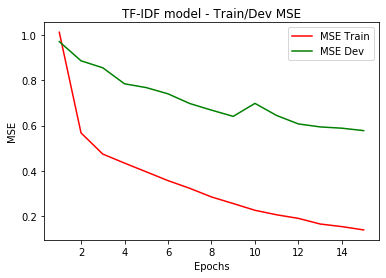

In [11]:
model=experiment(sampling_cls=UnderSampler,epochs=25,batch_size=500,name='TF-IDF model')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20000200  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 20,000,401
Trainable params: 20,000,401
Non-trainable params: 0
_________________________________________________________________


## Persist

In [13]:
with open('/home/kvassay/data/z/models/E2/vectorizer.pickle','wb') as f:
    pickle.dump(vectorizer,f)
model.save('/home/kvassay/data/z/models/E2/keras_regressor.h5')